# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
import pickle


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


In [2]:
print(STOPWORDS)

{'in', 'who', 'yours', 'any', 'there', 'll', 'why', 'what', "needn't", 'such', 'until', 'because', "hasn't", 'its', 'myself', 'ours', 'some', "haven't", 'don', 's', 'will', 'y', 'whom', "should've", 'was', 'with', 'themselves', 'during', 'before', 'down', 'being', 'above', 'but', "mightn't", 'very', "won't", 'through', 'hadn', 'theirs', 'am', 'under', 'for', 't', 'of', 'o', 'them', 'by', 'to', 'here', 'our', 'we', "shan't", 'weren', "hadn't", 'wouldn', 'himself', 'be', 've', 'too', 'how', 'between', 'which', 'these', 'on', 'd', 'm', 'ain', 'against', 'itself', 'mightn', 'shan', 'it', "couldn't", 'same', 'doing', 'more', 'not', 'now', 'from', 'aren', 'had', 'needn', 'and', 'yourselves', "you'd", 'you', 'or', 'only', 'haven', 'has', 'is', "don't", 'again', "aren't", 'her', 'this', 'just', 'ma', "mustn't", 'yourself', "that'll", 'do', 'shouldn', 'his', 'mustn', "didn't", "you'll", 'did', 'both', "wouldn't", 'should', 'all', 'hers', 'once', "you've", 'nor', 'further', 'been', 'the', 'herse

#  Hyperparams

In [3]:
ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'amazon_full' )
ALL_DF_CSV = os.path.join(DATASET_PATH, 'all_df.csv')

OUTPUT_PATH = os.path.join(ROOT, 'output', 'bert')

TRAIN_DATAPATH = os.path.join(DATASET_PATH, 'train.csv')
TEST_DATAPATH = os.path.join(DATASET_PATH, 'test.csv')

SAMPLE_SIZE = 0.2
TEST_SAMPLE_SIZE = 0.1

CLEANED_TRAIN_DATAPATH = os.path.join(DATASET_PATH, f'cleaned_train_{int(SAMPLE_SIZE*100)}%.csv')
CLEANED_TEST_DATAPATH = os.path.join(DATASET_PATH, f'cleaned_test_{int(TEST_SAMPLE_SIZE*100)}%.csv')

if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)


# Load the whole dataset and truncate it (for experiments)

In [4]:
# train_txt = bz2.BZ2File(os.path.join(datasetpath, 'train.ft.txt.bz2'))
# train_txt = bz2.BZ2File('/content/drive/MyDrive/UB/Sem 2/DL/DL FINAL Project/train.ft.txt.bz2')

# train_txt = bz2.BZ2File(DATASET_PATH)
# train_lines = train_txt.readlines()

In [5]:
train_df = pd.read_csv(TRAIN_DATAPATH, names = ["review", "title","text"])
train_df = train_df.sample(frac = SAMPLE_SIZE)
train_df.reset_index(inplace = True, drop = True)
train_df.head()
# print(train_df.shape)
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
train_df['review'] = train_df['review'].map(label_map)
print(train_df.shape)
print(train_df['review'].value_counts())
train_df.head()

(600000, 3)
review
4    120423
2    120201
1    119920
0    119745
3    119711
Name: count, dtype: int64


,review,title,text
0,1,Meh,They tried to do their own take on some of the...
1,0,"cheap imitation of ""The Ring""",This movie tried really hard to copy The Ring ...
2,0,Boring,"I didn't really like Montana 1948, because it ..."
3,3,Outstanding Recording,Recently saw Ann in person with the Cleveland ...
4,1,I Just Didn't Get it,I'm sorry but I just don't agree with all thes...


In [6]:
test_df = pd.read_csv(TEST_DATAPATH, names = ["review", "title","text"])
test_df = test_df.sample(frac = TEST_SAMPLE_SIZE)
test_df.reset_index(inplace = True, drop = True)
test_df.head()
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
test_df['review'] = test_df['review'].map(label_map)
test_df.reset_index(inplace=True, drop = True)
print(test_df['review'].value_counts())
print(test_df.shape)
test_df.head()

review
3    13124
1    13103
2    12952
4    12913
0    12908
Name: count, dtype: int64
(65000, 3)


,review,title,text
0,3,Saved by Eli & Jo,Clfford Odets play with a lot of depression an...
1,3,sorting the canon,when the cure's oeuvre IS finally done and thi...
2,3,AMG Review,The second album from this accomplished young ...
3,0,Cant hear the sound/music,I bought this product because of the high rati...
4,2,no better then for what they cost,these are your normal (really cheap) in earpho...


# Clean text

In [7]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    # text = remove_stopwords(text)

    #__label__1 = 0: bad review, __label__2 = 1,good review
    text = ' '.join(t for t in text.split() if t != '')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)

'this is a test string here are some special characters how about some punctuations _'

In [8]:
train_df['text'] = train_df['text'].apply(lambda s: clean_text(s))
test_df['text'] = test_df['text'].apply(lambda s: clean_text(s))

# Check data integrity, missing values and bad values

In [9]:
print('train df')
train_df.dropna(inplace=True)
print(train_df.isna().sum())
print('train df = ', train_df.shape)
print('test df')
test_df.dropna(inplace=True)
print(test_df.isna().sum())
print('test df = ' ,test_df.shape)

train df
review    0
title     0
text      0
dtype: int64
train df =  (599962, 3)
test df
review    0
title     0
text      0
dtype: int64
test df =  (64994, 3)


# Save df

In [10]:
train_df.to_csv(CLEANED_TRAIN_DATAPATH, index=False)
test_df.to_csv(CLEANED_TEST_DATAPATH, index=False)


In [11]:
print(test_df.shape)
test_df.head()

(64994, 3)


,review,title,text
0,3,Saved by Eli & Jo,clfford odets play with a lot of depression an...
1,3,sorting the canon,when the cure s oeuvre is finally done and thi...
2,3,AMG Review,the second album from this accomplished young ...
3,0,Cant hear the sound/music,i bought this product because of the high rati...
4,2,no better then for what they cost,these are your normal really cheap in earphone...


In [12]:
# eda_df = train_df.copy()
# eda_df['text'] = eda_df['text'].apply(lambda s: clean_text(s))
train_df['lengths'] = train_df['text'].apply(lambda s: len(s))

test_df['lengths'] = test_df['text'].apply(lambda s: len(s))


# Stats
train_df.describe()

,review,lengths
count,599962.000000,599962.000000
mean,2.001940,403.339041
std,1.414403,231.117731
min,0.000000,0.000000
25%,1.000000,207.000000
50%,2.000000,357.000000
75%,3.000000,566.000000
max,4.000000,1010.000000


In [13]:
test_df.describe()

,review,lengths
count,64994.000000,64994.000000
mean,2.000477,404.812829
std,1.411562,231.592101
min,0.000000,0.000000
25%,1.000000,209.000000
50%,2.000000,358.000000
75%,3.000000,568.000000
max,4.000000,995.000000


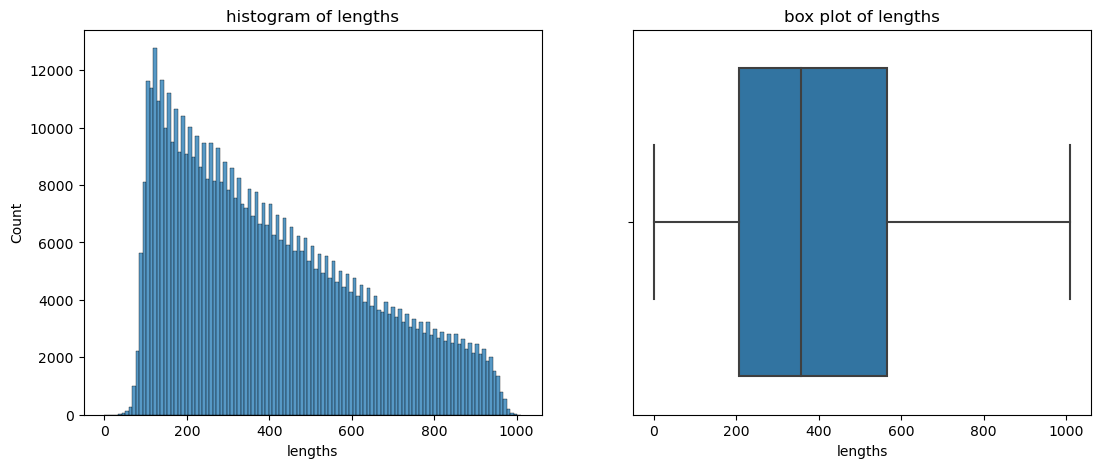

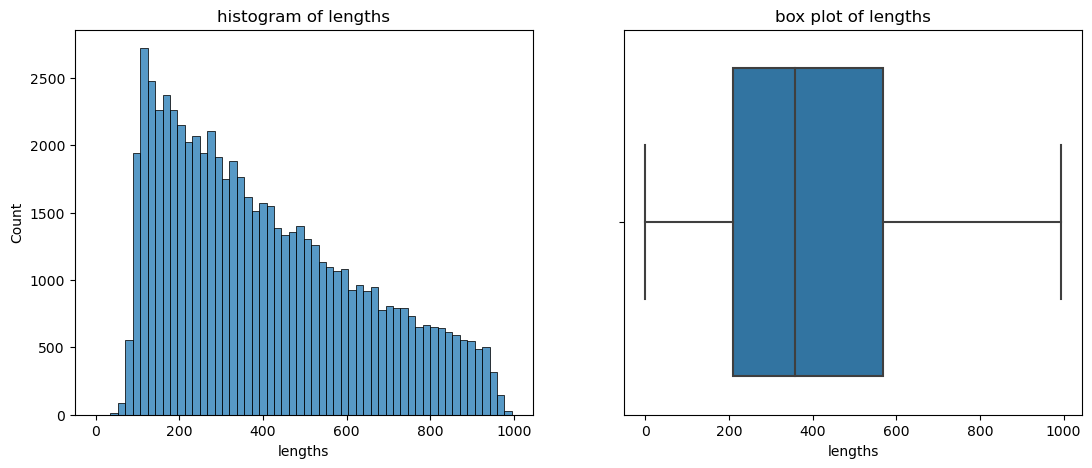

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.histplot(train_df, x = 'lengths', ax = ax1)
ax1.set_title('histogram of lengths')
sns.boxplot(train_df, x = 'lengths', ax = ax2)
ax2.set_title('box plot of lengths')
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.histplot(test_df, x = 'lengths', ax = ax1)
ax1.set_title('histogram of lengths')
sns.boxplot(test_df, x = 'lengths', ax = ax2)
ax2.set_title('box plot of lengths')
plt.show()

# A little EDA

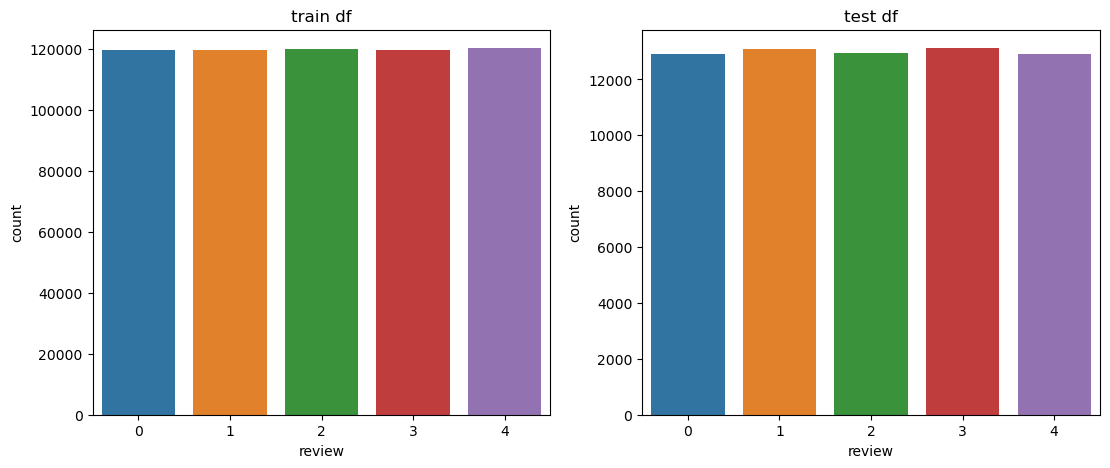

In [15]:
# bad_reviews = eda_df.loc[eda_df['review'] == 1]['text'].apply(lambda s: len(s)).values
# good_reviews = eda_df.loc[eda_df['review'] == 2]['text'].apply(lambda s: len(s)).values
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.countplot(train_df, x = 'review', ax = ax1)
ax1.set_title('train df')
sns.countplot(test_df, x = 'review', ax = ax2)
ax2.set_title('test df')
plt.show()